# College: Is It Worth the Cost?
Metis Linear Regression Module Final Project

Max Harrington

August 6th, 2021


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re

#maybe pandas read_html for tables

The code below captures the data of each webpage

In [2]:
# Get school ids from website database
school_names = pd.read_csv("School Names - Sheet1.csv")
ids = school_names["UnitID"]

In [3]:
# # Template URL
# main_url = "https://nces.ed.gov/collegenavigator/?id="

# # Pull text from each site
# school_dict = {}
# counter = 0
# for i in ids:
#     tempurl = main_url+str(i)
#     school = requests.get(tempurl)
#     school_page = school.text
#     try:    
#         school_dict[i] = school_page
#         counter += 1
#         if counter>100:
#             print("cool")
#             counter = 0
#     except:
#         print(i)
        
        
# #converts the texts to pandas series and saves as CSV for future use
# school_texts = pd.Series(school_dict)
# school_texts.to_csv("school_texts.csv")
    
    

Take given texts and turn into beautiful soup object

In [4]:
school_texts = pd.read_csv("school_texts.csv", header = 0, names = ["ID", "text"], index_col = "ID",)
school_soups = school_texts["text"].apply(lambda text: BeautifulSoup(text, 'lxml'))
school_soups.head()


ID
100654    [html PUBLIC "-//W3C//DTD XHTML 1.0 Transition...
100663    [html PUBLIC "-//W3C//DTD XHTML 1.0 Transition...
100690    [html PUBLIC "-//W3C//DTD XHTML 1.0 Transition...
100706    [html PUBLIC "-//W3C//DTD XHTML 1.0 Transition...
100724    [html PUBLIC "-//W3C//DTD XHTML 1.0 Transition...
Name: text, dtype: object

In [5]:
exampler = BeautifulSoup(requests.get("https://nces.ed.gov/collegenavigator/?id=203535").text, "lxml")
exampler2 = BeautifulSoup(requests.get("https://nces.ed.gov/collegenavigator/?id=131496").text, "lxml")


helper functions

In [6]:
def tables(example):
    return example.find_all("table", class_ = "tabular")
def graph_tables(example):
    return example.find_all("table", class_ = "graphtabs")
def cleaner (item, punctuation= ",()/$%:-'", letters = True, sep = True, inty = False):
    try:
        remove_these = list(punctuation)
        if pd.isna(item):
            return item
        item = str(item)
        for i in remove_these:
            item = item.replace(i, "")
        if letters == True:
            item = re.sub("[A-Za-z]","",item)
            item = re.sub("\s+"," ", item.strip())
        if inty == True:
            return int(item)
        if sep == True:
            return item.split(" ")
        return item
    except:
        return np.nan


In [7]:
df = pd.DataFrame(school_soups.copy())

This function pulls the top table of data, giving important location, population, ratio data.

In [8]:
def overall (school):   

    try:
        top_table = [i.get_text(strip = True) for i in school.find("table", class_ = "layouttab").find_all('td')]
        result = top_table
    except:
        return np.nan
    try:    
        school_type = top_table[result.index('Type:') + 1]

    except:
        school_type = np.nan
    try:   
        awards = top_table[result.index('Awards offered:') + 1]
    except:
        awards = np.nan
    try:   
        setting = top_table[result.index('Campus setting:') + 1]
    except:
        setting = np.nan
    try:
        population = top_table[result.index('Student population:') + 1]
    except:
        population = np.nan
    try:    
        ratio = int(cleaner(top_table[result.index('Student-to-faculty ratio:') + 1])[0])
    except:
        ratio = np.nan
    try:
        total_pop = int(cleaner(population)[0])
    except:
        total_pop = np.nan
    try:
        under_pop = int(cleaner(population)[1])
    except:
        under_pop = np.nan
    return[school_type, awards, setting, total_pop, under_pop, ratio]


apply top data, drop dead pages

In [9]:
df["options"] = df["text"].apply(overall)
df[["school_type", "awards", "setting", "total_pop", "under_pop", "ratio"]] = df.options.apply(pd.Series)
df.dropna(subset = ["total_pop", "ratio"], inplace = True)
df.shape

(2357, 8)

Anything missing under_pop is set as an undergrad

pulls the school's costs

In [10]:
#costs
def costs (school):
    try:
        expenses = list(filter(None, [i.get_text(strip = True) for i in tables(school)[1].find_all("td")]))
    except:
        return np.nan
    #state school
    if expenses.count("In-state") >0:
        state_school = 1
        tuition = expenses[expenses.index("In-state")+4]
        out_state_tuition = expenses[expenses.index("Out-of-state")+4]

    else:
        state_school = 0
        out_state_tuition = np.nan
        try:
            tuition = expenses[expenses.index("Tuition and fees")+4]
        except:
            tuition = np.nan

    try:
        books = expenses[expenses.index("Books and supplies")+4]
    except:
        books = np.nan
    try:
        R_B = expenses[expenses.index("On Campus")+5]
    except:
        R_B = np.nan
    try:
        Other = expenses[expenses.index("Other")+4]
    except:
        Other = np.nan
    try:
        R_B_O = expenses[expenses.index("Off Campus")+5]
    except:
        R_B_O = np.nan

    final_costs = [state_school, tuition, out_state_tuition, books, R_B, Other, R_B_O]
    #final_costs = [np.nan if pd.isna(i) else int(cleaner(i, sep = False)) for i in final_costs]
    return final_costs

In [11]:
df["costs"] = df["text"].apply(costs)
df.dropna(subset = ["costs"], inplace = True)
df[["state_school", "tuition", "out_state_tuition", "books", "R_B", "Other", "R_B_O"]] = df.costs.apply(pd.Series)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 100654 to 495767
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2357 non-null   object 
 1   options            2357 non-null   object 
 2   school_type        2357 non-null   object 
 3   awards             2357 non-null   object 
 4   setting            2357 non-null   object 
 5   total_pop          2357 non-null   float64
 6   under_pop          1675 non-null   float64
 7   ratio              2357 non-null   float64
 8   costs              2357 non-null   object 
 9   state_school       2357 non-null   float64
 10  tuition            2190 non-null   object 
 11  out_state_tuition  664 non-null    object 
 12  books              2106 non-null   object 
 13  R_B                1700 non-null   object 
 14  Other              2190 non-null   object 
 15  R_B_O              2122 non-null   object 
dtypes: float64(4), ob

In [12]:
df2= df.copy()


In [13]:
# financial aid
def fin_aid (school):

    string_options= ['Grant or scholarship aid','Grant or scholarship aid1','Student loan aid', 'Federal student loans' ]
    for k in range(0,10):
        try:
            aid = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
        except:
            pass
        solutions = []
        for text in string_options:
            try:
                int(aid[aid.index(text)+1][0])
                solutions.append(aid[aid.index(text)+1])                              
            except:
                pass
        if len(solutions)==1:
            return np.nan
        
        if len(solutions)>1:
            return solutions[:2]

    return np.nan
            
                
        



In [14]:
df2["fin_aid"] = df2["text"].apply(fin_aid)
df2.dropna(subset = ["fin_aid"], inplace = True)
df2[["total_grants", "total_loans"]] = df2["fin_aid"].apply(pd.Series)


In [15]:
df3 = df2.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 100654 to 495767
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2325 non-null   object 
 1   options            2325 non-null   object 
 2   school_type        2325 non-null   object 
 3   awards             2325 non-null   object 
 4   setting            2325 non-null   object 
 5   total_pop          2325 non-null   float64
 6   under_pop          1654 non-null   float64
 7   ratio              2325 non-null   float64
 8   costs              2325 non-null   object 
 9   state_school       2325 non-null   float64
 10  tuition            2165 non-null   object 
 11  out_state_tuition  662 non-null    object 
 12  books              2081 non-null   object 
 13  R_B                1694 non-null   object 
 14  Other              2165 non-null   object 
 15  R_B_O              2099 non-null   object 
 16  fin_aid          

In [16]:
#enrollment
def enrollment(school):
    try:    
        graph_data = graph_tables(school)
    except:
        return np.nan
    try:
        fullorpart = graph_data[0].find_all("img")[0].get("alt")
    except:
        fullorpart = np.nan
    try:
        gender = graph_data[0].find_all("img")[1].get("alt")
    except:
        gender = np.nan
    try: 
        ethnicity = graph_data[1].find("img").get("alt")
    except:
        ethnicity = np.nan
    try:
        age = graph_data[2].find("img").get("alt")
    except:
        age = np.nan
    try:
        residency = graph_data[2].find_all("img")[1].get("alt")
    except:
        residency = np.nan
    return [fullorpart, gender, ethnicity, age, residency]

   
# aid = list(filter(None, [i.get_text(strip = True) for i in graph_tables(exampler)[5].find_all("td")]))


In [17]:
df3["enrollment"] = df3["text"].apply(enrollment)
df3.dropna(subset = ["enrollment"], inplace = True)
df3[["fullorpart", "gender", "ethnicity", "age", "residency"]] = df3["enrollment"].apply(pd.Series)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 100654 to 495767
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2325 non-null   object 
 1   options            2325 non-null   object 
 2   school_type        2325 non-null   object 
 3   awards             2325 non-null   object 
 4   setting            2325 non-null   object 
 5   total_pop          2325 non-null   float64
 6   under_pop          1654 non-null   float64
 7   ratio              2325 non-null   float64
 8   costs              2325 non-null   object 
 9   state_school       2325 non-null   float64
 10  tuition            2165 non-null   object 
 11  out_state_tuition  662 non-null    object 
 12  books              2081 non-null   object 
 13  R_B                1694 non-null   object 
 14  Other              2165 non-null   object 
 15  R_B_O              2099 non-null   object 
 16  fin_aid          

In [18]:

def admissions (school):
    string_options= ['Number of applicants', 'Percent admitted', 'Secondary school GPA', 'Admission test scores (SAT/ACT)', "SAT Evidence-Based Reading and Writing", "SAT Math", "ACT Composite"]
    results = []
    for k in range(0,20):

        
        try:
            temp = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
            temp.index(string_options[0])
            admissions_demos = temp  

            for text in string_options[0:2]:
                for count in range(1,4):
                    try:
                        results.append(admissions_demos[admissions_demos.index(text)+count])                    
                    except:
                        pass

        except:
            pass
            
        try:    
            temp = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
            temp.index(string_options[4])
            scores = temp
            for text in string_options[4:]:
                try:
                    results.append(scores[scores.index(text)+1])
                    results.append(scores[scores.index(text)+2])
                except:
                    pass
                
        except:
            pass
        
        try:
            temp = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
            temp.index(string_options[2])
            requireds = temp
            for text in string_options[2:4]:
                try:
                    results.append((requireds[requireds.index(text)+1] == "X"))
                except:
                    pass
            
        except:
            pass
        
    if len(results) == 14:   
        return results
    return np.nan



In [19]:
df4 = df3.copy()
df4["admissions"] = df4["text"].apply(admissions)
# df4.dropna(subset = ["admissions"], inplace = True)
df4[["total_apps", "male_apps", "female_apps", "total_percent", "perc_male_admit", "perc_female_admit", "gpa", "test_scores", "SAT_WR_25", "SAT_WR_75", "SAT_M_25", "SAT_M_75", "ACT_C_25", "ACT_C_75"]] = df4["admissions"].apply(pd.Series)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 100654 to 495767
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2325 non-null   object 
 1   options            2325 non-null   object 
 2   school_type        2325 non-null   object 
 3   awards             2325 non-null   object 
 4   setting            2325 non-null   object 
 5   total_pop          2325 non-null   float64
 6   under_pop          1654 non-null   float64
 7   ratio              2325 non-null   float64
 8   costs              2325 non-null   object 
 9   state_school       2325 non-null   float64
 10  tuition            2165 non-null   object 
 11  out_state_tuition  662 non-null    object 
 12  books              2081 non-null   object 
 13  R_B                1694 non-null   object 
 14  Other              2165 non-null   object 
 15  R_B_O              2099 non-null   object 
 16  fin_aid          

In [20]:
#outcomes
def outcomes (school):
    try:    
        graph_data = [i.find_all("img")[0].get("alt").strip() for i in graph_tables(school)]
    except:
        return np.nan
    for info in graph_data:
        if info.find("Overall")!=-1:
            return int(cleaner(info)[0])
    return np.nan
#         try:
#             retention_rate = graph_data[5].find_all("img")[0].get("alt")
#         except:
#             retention_rate = np.nan
#         try:    
#             graduation_rate = graph_data[6].find_all("img")[0].get("alt")
#         except:
#             graduation_rate = np.nan
#         try:
#             gen_grad_rates = graph_data[8].find_all("img")[0].get("alt")
#         except:
#             gen_grad_rates = np.nan
#         try:
#             eth_grad_rates = graph_data[9].find_all("img")[0].get("alt")
#         except:
#             eth_grad_rates = np.nan

#     return [retention_rate, graduation_rate, gen_grad_rates, eth_grad_rates]

In [21]:
# df4.to_csv("temp")
df4.age.head()

ID
100654    Undergraduate Student Age:\r\n24 and under: 96...
100663    Undergraduate Student Age:\r\n24 and under: 80...
100706    Undergraduate Student Age:\r\n24 and under: 85...
100724    Undergraduate Student Age:\r\n24 and under: 93...
100751    Undergraduate Student Age:\r\n24 and under: 92...
Name: age, dtype: object

In [22]:
df5 = df4.copy()
df5["grad_rate"] = df5["text"].apply(outcomes)
df5.dropna(subset = ["grad_rate"], inplace = True)

df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 100654 to 495767
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2168 non-null   object 
 1   options            2168 non-null   object 
 2   school_type        2168 non-null   object 
 3   awards             2168 non-null   object 
 4   setting            2168 non-null   object 
 5   total_pop          2168 non-null   float64
 6   under_pop          1538 non-null   float64
 7   ratio              2168 non-null   float64
 8   costs              2168 non-null   object 
 9   state_school       2168 non-null   float64
 10  tuition            2096 non-null   object 
 11  out_state_tuition  660 non-null    object 
 12  books              2016 non-null   object 
 13  R_B                1679 non-null   object 
 14  Other              2096 non-null   object 
 15  R_B_O              2033 non-null   object 
 16  fin_aid          

In [23]:
#removed this code as the value was not inherently useful/each school had different categories

# def top_major (school):
#     try:
#         majors_counts = list(filter(None, [i.get_text(strip = True) for i in school.find("table", class_ = "pmtabular").find_all("td")]))
#         locations = []
#         for i, statement in enumerate(majors_counts):
#             if statement == "Category total":
#                 locations.append(i)
#         categories = [majors_counts[1]]
#         for j in locations:
#             categories.append(majors_counts[j+7])
#         totals = {}
#         for k, bachs in enumerate(locations):
#             totals[categories[k]] = majors_counts[bachs+2]
#         return totals
    
#     except:
#         pass
#     try:
#         majors_counts = list(filter(None, [i.get_text(strip = True) for i in school.find("table", class_ = "pmtabular").find_all("td")]))
#         locations = []
#         for i, statement in enumerate(majors_counts):
#             if statement == "Category total":
#                 locations.append(i)
#         categories = [majors_counts[1]]
#         for j in locations:
#             categories.append(majors_counts[j+2])
#         totals = {}
#         for k, bachs in enumerate(locations):
#             totals[categories[k]] = majors_counts[bachs+1]
#         return totals
#     except:   
#          pass
#     return np.nan
    
    

        

In [24]:
#Sports
def sports(school):
    for k in range(10,20):
        try:
            sport_table = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
            sport_checker = ['Baseball', 'Basketball', 'Field Hockey', 'Football', 'Golf', 'Lacrosse', 'Soccer', 'Softball',  'Swimming and Diving', 'Tennis',  'Track and Field, Indoor', 'Track and Field, Outdoor',  'Track and Field, X-Country',  'Volleyball'] 
            if any(map(lambda x: x in sport_table, sport_checker)):
                athletes = 0
                for i in sport_table:
                    try:
                        athletes += int(i) 
                    except:
                        pass
                return athletes                                    
        except:
            pass
        
    return np.nan
            
sports(exampler)
            

623

In [25]:
def crime (school):
    for k in range(0,20):
        try:
            crime = list(filter(None, [i.get_text(strip = True) for i in tables(school)[k].find_all("td")]))
            breaks = [crime.index("VAWA Offenses"),crime.index('Arrests'),crime.index('Disciplinary Actions')]
            criminal_offenses = 0
            try:
                for i in crime[5:breaks[0]]:
                    try:
                        criminal_offenses += int(i)
                    except:
                        pass
            except:
                criminal_offenses = np.nan
            VAWA_offenses = 0
            try:
                for i in crime[breaks[0]+4:breaks[1]]:
                    try:
                        VAWA_offenses += int(i)
                    except:
                        pass
            except:
                VAWA_offenses = np.nan
            try:
                arrests = 0
                for i in crime[breaks[1]+4:breaks[2]]:
                    try:
                        arrests  += int(i)
                    except:
                        pass
            except:
                arrests = np.nan
            return [criminal_offenses, VAWA_offenses, arrests]
        except:
            pass




In [26]:
df6 = df5.copy()
# df6["majors"] = df6["text"].apply(top_major)
df6["sports"] = df6["text"].apply(sports)
df6["crime"] = df6["text"].apply(crime)


In [27]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 100654 to 495767
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               2168 non-null   object 
 1   options            2168 non-null   object 
 2   school_type        2168 non-null   object 
 3   awards             2168 non-null   object 
 4   setting            2168 non-null   object 
 5   total_pop          2168 non-null   float64
 6   under_pop          1538 non-null   float64
 7   ratio              2168 non-null   float64
 8   costs              2168 non-null   object 
 9   state_school       2168 non-null   float64
 10  tuition            2096 non-null   object 
 11  out_state_tuition  660 non-null    object 
 12  books              2016 non-null   object 
 13  R_B                1679 non-null   object 
 14  Other              2096 non-null   object 
 15  R_B_O              2033 non-null   object 
 16  fin_aid          

In [28]:
df6.sports.isna()

ID
100654    False
100663    False
100706    False
100724    False
100751    False
          ...  
493600     True
493664     True
493707     True
494685     True
495767    False
Name: sports, Length: 2168, dtype: bool

In [29]:
final_df = df6.copy().drop(["text","options","costs","fin_aid","enrollment", "admissions", "out_state_tuition"], axis = 1)


After the final data set is found, the features need to be cleaned. While I removed a lot of the code experimenting with why each feature requires it's respective cleaning, each one had to be analyzed for outliers, nan values, and formatting. Additionally, many of the features removed did not perform well in modeling.

In [30]:
#transformed these features to better match the needs of the analysis
final_df["public"] = final_df["school_type"].str.contains("Public").astype(int)
final_df["masters"] = final_df["awards"].str.contains("Master's").astype(int)
final_df["setting"] = final_df["setting"].str.replace(":[\s\w]+","")
final_df["grad_students"] = final_df["total_pop"]-final_df["under_pop"].fillna(0)

#cleaned these features for analysis
for column in ["tuition", "R_B", "R_B_O", "books","total_grants", "total_loans", 'total_apps', 'total_percent',
       'SAT_WR_25', 'SAT_WR_75', 'SAT_M_25', 'SAT_M_75', 'ACT_C_25',
       'ACT_C_75']:
    final_df[column] = final_df[column].apply(cleaner, inty = True)


#filled missing values for catgories below, depending on what makes sense for each variable
final_df["R_B_O"].fillna(final_df["R_B"], inplace =True)
final_df["R_B"].fillna(final_df["R_B_O"], inplace =True)
final_df["sports"].fillna(0, inplace = True)
final_df["books"].fillna(final_df["books"].median(), inplace = True)


#rather than creating large groups of dummy variables (ex. ethnicity contained 7 different variables), I reduced each category into a binary percentage (ex. white/non-white)
final_df["full_time_perc"] = final_df["fullorpart"].apply(cleaner).apply(lambda x : x[0]).astype("int")
final_df["male_perc"] = final_df["gender"].apply(cleaner).apply(lambda x : x[0]).astype("int")
final_df["white_perc"] = final_df["ethnicity"].apply(cleaner).apply(lambda x: x[5]).astype("int")
final_df["young_perc"] = final_df["age"].apply(cleaner).apply(lambda x: x[1]).astype("int")
final_df["in_state_perc"] = final_df["residency"].apply(cleaner).apply(lambda x: x if isinstance(x, float) is True else x[0]).astype("float")



#split crimes into multiple categories
final_df[["crimes", "VAWA", "arrests"]] = final_df["crime"].apply(pd.Series)


#combined test scores to prevent multicoliniarity
final_df["test_score"] = final_df[['SAT_WR_25', 'SAT_WR_75', 'SAT_M_25', 'SAT_M_75']].mean(axis=1)
final_df.rename(columns = {"total_percent":"acceptance_perc"}, inplace = True)

#dummy variables for setting 
final_df[["rural", "suburb", "town"]] = pd.get_dummies(final_df.setting, drop_first=True)



I dropped several of the features from the data set, for the following reasons:
1. The feature was split up into multiple subcategories (crime)
2. The feature was highly colinear with others (population statistics or test scores) or was a binary variable covered by another non-binary variable (masters, which looks at whether a school has graduate students, is covered by grad_students, which gives a count for graduate students)
3. The feature had irreperable errors, either from scraping errors or lack of data (majors)
4. the feature had inversely related variables, so only one was needed (gender only requires male or female percentage, not both)



In [31]:

final_df.drop(["school_type", "awards", "Other", "under_pop", "fullorpart", "gender","male_apps", "female_apps", "perc_male_admit", "perc_female_admit","gpa", "test_scores","ethnicity", "age", "residency", "crime", 'SAT_WR_25', 'SAT_WR_75', 'SAT_M_25', 'SAT_M_75', 'ACT_C_25', 'ACT_C_75', 'total_loans', "state_school", "masters", "R_B", "setting"], axis = 1, inplace = True)






In [32]:
#data is cleaned for remaining na values
final_df.dropna(subset = ["total_apps","tuition", "crimes"], inplace = True)


#data set is reordered for final analysis
final_df = final_df[["tuition", "total_pop", "ratio", "public","test_score", "R_B_O", "total_grants", "total_apps", "acceptance_perc", "grad_rate", "sports", "grad_students", "full_time_perc", "male_perc", "white_perc", "young_perc", "in_state_perc", "crimes", "VAWA", "arrests", "rural", "suburb", "town"]]

final_df = final_df.astype(int)




Now that everything is clean and ready, the data is explored.

In [33]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 100654 to 495767
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tuition          1021 non-null   int64
 1   total_pop        1021 non-null   int64
 2   ratio            1021 non-null   int64
 3   public           1021 non-null   int64
 4   test_score       1021 non-null   int64
 5   R_B_O            1021 non-null   int64
 6   total_grants     1021 non-null   int64
 7   total_apps       1021 non-null   int64
 8   acceptance_perc  1021 non-null   int64
 9   grad_rate        1021 non-null   int64
 10  sports           1021 non-null   int64
 11  grad_students    1021 non-null   int64
 12  full_time_perc   1021 non-null   int64
 13  male_perc        1021 non-null   int64
 14  white_perc       1021 non-null   int64
 15  young_perc       1021 non-null   int64
 16  in_state_perc    1021 non-null   int64
 17  crimes           1021 non-null   int64
 18  V

In [34]:
final_df.describe()

#Only curious result is the maximum white_perc being 93; while there are no exclusively white institutions, one would expect some student bodies to be more homogenous.
#Otherwise, the cleaning above removed all erronious outliers/incorrect values

tuition     total_pop        ratio       public   test_score  \
count   1021.000000   1021.000000  1021.000000  1021.000000  1021.000000   
mean   26076.591577   8504.726738    13.678746     0.382958   562.976494   
std    16137.775353  11549.148142     4.095266     0.486346    67.447535   
min     1095.000000     63.000000     3.000000     0.000000   375.000000   
25%    10732.000000   1629.000000    11.000000     0.000000   518.000000   
50%    25280.000000   3506.000000    13.000000     0.000000   550.000000   
75%    37030.000000  10477.000000    16.000000     1.000000   597.000000   
max    61671.000000  91427.000000    30.000000     1.000000   777.000000   

              R_B_O  total_grants     total_apps  acceptance_perc  \
count   1021.000000   1021.000000    1021.000000      1021.000000   
mean   10881.542605    974.292850    9097.163565        69.199804   
std     3326.775756   1203.980259   13193.561120        20.374177   
min     1000.000000      8.000000      18.000000         5.000000   
25%     8650.000000    269.000000    1763.000000        60.000000   
50%    10562.000000    511.000000    4169.000000        73.000000   
75%    13070.000000   1166.000000    9890.000000        83.000000   
max    25000.000000  12468.000000  100062.000000       100.000000   

         grad_rate  ...    male_perc   white_perc   young_perc  in_state_perc  \
count  1021.000000  ...  1021.000000  1021.000000  1021.000000    1021.000000   
mean     59.911851  ...    43.037218    56.535749    86.822723      64.785504   
std      17.144543  ...    11.872302    21.289599    11.724573      25.052299   
min       8.000000  ...     0.000000     0.000000    34.000000       1.000000   
25%      48.000000  ...    38.000000    45.000000    81.000000      48.000000   
50%      59.000000  ...    43.000000    61.000000    90.000000      70.000000   
75%      72.000000  ...    48.000000    73.000000    96.000000      86.000000   
max      98.000000  ...   100.000000    93.000000   100.000000     100.000000   

            crimes         VAWA      arrests        rural       suburb  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000   
mean     53.621939    26.914789    78.468168     0.047013     0.232125   
std      83.003638    43.985465   201.019271     0.211770     0.422395   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      12.000000     4.000000     1.000000     0.000000     0.000000   
50%      30.000000    11.000000     8.000000     0.000000     0.000000   
75%      64.000000    31.000000    57.000000     0.000000     0.000000   
max    1598.000000   523.000000  2858.000000     1.000000     1.000000   

              town  
count  1021.000000  
mean      0.242899  
std       0.429045  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  

[8 rows x 23 columns]

In [35]:
final_df.corr()

#glad to see that the only strong correlations appear between population based statistics. Definitely will still need to control for this.
#tution seems initial connected to public v private and student/faculty ratio.


tuition  total_pop     ratio    public  test_score  \
tuition          1.000000  -0.290838 -0.617828 -0.784061    0.499236   
total_pop       -0.290838   1.000000  0.488051  0.491754    0.334371   
ratio           -0.617828   0.488051  1.000000  0.619039   -0.214424   
public          -0.784061   0.491754  0.619039  1.000000   -0.093452   
test_score       0.499236   0.334371 -0.214424 -0.093452    1.000000   
R_B_O            0.293696   0.217017 -0.056459  0.007791    0.452812   
total_grants    -0.317930   0.895291  0.516105  0.517284    0.258813   
total_apps      -0.047198   0.817376  0.275279  0.309283    0.488552   
acceptance_perc -0.394555  -0.089888  0.266637  0.210137   -0.531948   
grad_rate        0.536354   0.290868 -0.213053 -0.160205    0.842795   
sports           0.169203   0.381140  0.102556  0.058818    0.364168   
grad_students   -0.027848   0.807802  0.192704  0.212241    0.428615   
full_time_perc   0.419746  -0.026163 -0.203431 -0.213772    0.396359   
male_perc        0.001312   0.124352  0.091066  0.090236    0.203332   
white_perc       0.060955  -0.127921 -0.135896 -0.053448    0.144936   
young_perc       0.355501   0.039993 -0.116898 -0.096228    0.468794   
in_state_perc   -0.577848   0.114578  0.453900  0.478273   -0.465701   
crimes          -0.096587   0.658809  0.222185  0.305660    0.346784   
VAWA            -0.190644   0.685502  0.273264  0.381957    0.288083   
arrests         -0.282153   0.595829  0.318501  0.413576    0.113542   
rural           -0.032974  -0.130247 -0.062831 -0.070269   -0.123404   
suburb           0.104888  -0.063703 -0.037328 -0.056128    0.085466   
town            -0.119827  -0.188692  0.009302  0.056505   -0.176245   

                    R_B_O  total_grants  total_apps  acceptance_perc  \
tuition          0.293696     -0.317930   -0.047198        -0.394555   
total_pop        0.217017      0.895291    0.817376        -0.089888   
ratio           -0.056459      0.516105    0.275279         0.266637   
public           0.007791      0.517284    0.309283         0.210137   
test_score       0.452812      0.258813    0.488552        -0.531948   
R_B_O            1.000000      0.163634    0.352903        -0.272708   
total_grants     0.163634      1.000000    0.736804         0.026425   
total_apps       0.352903      0.736804    1.000000        -0.349662   
acceptance_perc -0.272708      0.026425   -0.349662         1.000000   
grad_rate        0.434113      0.252271    0.449546        -0.420298   
sports           0.132410      0.369445    0.424762        -0.211021   
grad_students    0.233818      0.590313    0.694817        -0.246031   
full_time_perc   0.252930      0.064382    0.185157        -0.238190   
male_perc        0.092953      0.135525    0.133543        -0.132315   
white_perc      -0.229859     -0.050151   -0.214482         0.162971   
young_perc       0.214999      0.142088    0.211470        -0.235023   
in_state_perc   -0.167172      0.146060   -0.060996         0.400035   
crimes           0.212133      0.622690    0.611000        -0.165254   
VAWA             0.201989      0.633723    0.571071        -0.084688   
arrests          0.038457      0.681812    0.449885         0.101241   
rural           -0.074887     -0.127526   -0.115220        -0.000589   
suburb           0.115561     -0.071148   -0.032117        -0.024077   
town            -0.266094     -0.152548   -0.198482         0.063866   

                 grad_rate  ...  male_perc  white_perc  young_perc  \
tuition           0.536354  ...   0.001312    0.060955    0.355501   
total_pop         0.290868  ...   0.124352   -0.127921    0.039993   
ratio            -0.213053  ...   0.091066   -0.135896   -0.116898   
public           -0.160205  ...   0.090236   -0.053448   -0.096228   
test_score        0.842795  ...   0.203332    0.144936    0.468794   
R_B_O             0.434113  ...   0.092953   -0.229859    0.214999   
total_grants      0.252271  ...   0.135525   -0.050151    0.142088   


# Modeling


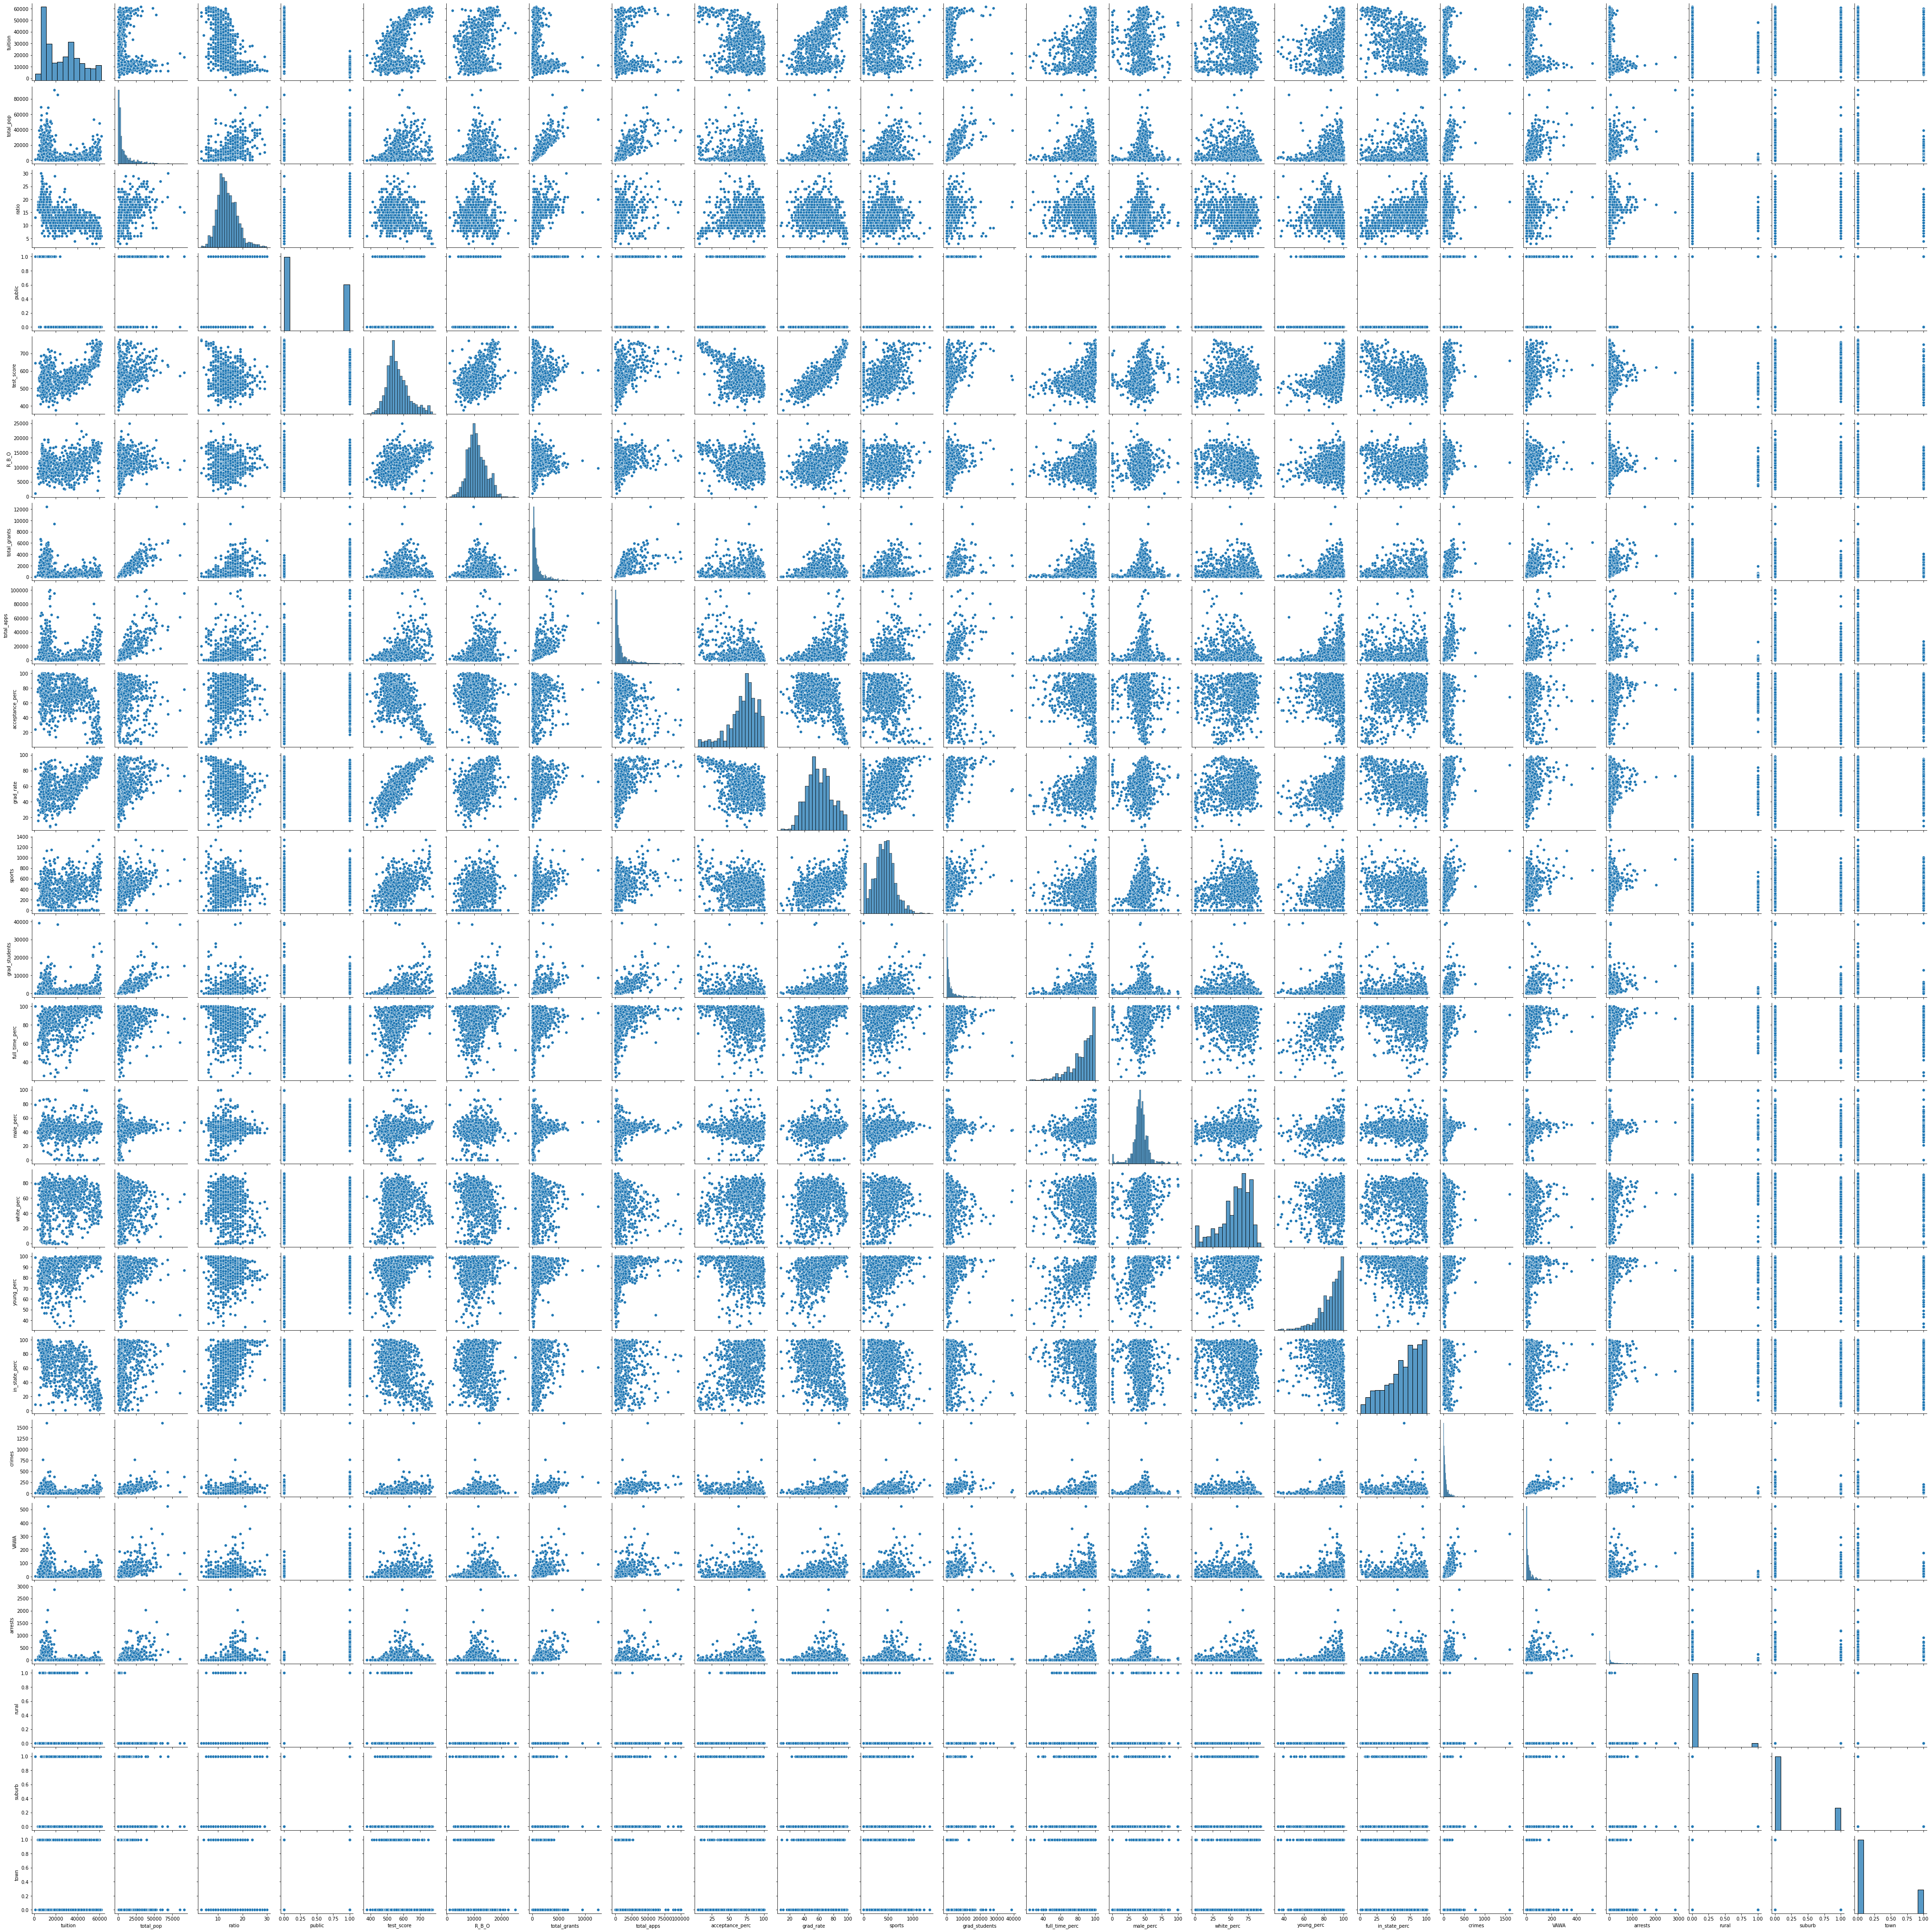

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(final_df)


# lots to unpack here. Anything population/demographic based appears to be logarithmic in nature. Several polynomial relationships also seem interesting


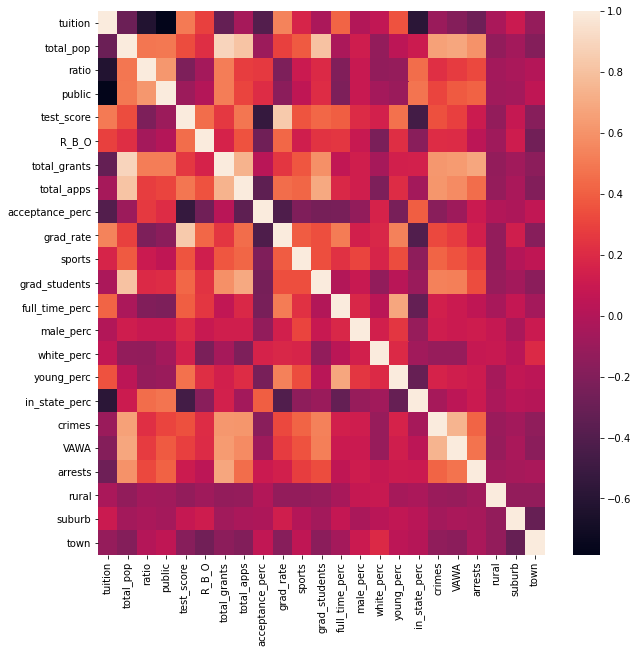

In [37]:
f, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(final_df.corr())




# possible relationships for feature engineering:
- total_students/total_grants
- square ratio, test score, acceptance perc, full_time_perc
- log percents
- total_students/crime rate
- young_white_male
 

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import scipy.stats as stats


#standardize and prepare datasets for analsysis
X_total = final_df.iloc[:,1:]
y_total = final_df["tuition"]


# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X_total, y_total, test_size=.2, random_state=5)

# hold out 20% for validation in non-CV tests
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=10)

scaler = StandardScaler()

#scaled data, values used to not interfere with columns

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_scaled = scaler.transform(X.values)
X_total_scaled = scaler.transform(X_total.values)
X_test_scaled = scaler.transform(X_test.values)

#create polynomial features
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_scaled_poly = poly.transform(X.values)
X_test_poly = poly.transform(X_test.values)




In [39]:
lm = LinearRegression()

lm_poly=LinearRegression()

In [40]:




lm.fit(X_train, y_train)
print(lm.score(X_val, y_val))

lm_poly.fit(X_train_poly, y_train)
print(lm_poly.score(X_val_poly, y_val))

lm.fit(X, y)
print(lm.score(X_test, y_test))

lm_poly.fit(X_train_poly, y_train)
print(lm_poly.score(X_test_poly, y_test))

0.877191800913385
0.6995895007238848
0.8480690285304313
0.5716318645075255


In [41]:
#linear initially looks best

np.mean(cross_val_score(lm, X, y, cv=5, scoring='r2'))


0.8341813203535109

In [42]:
alphavec = 10**np.linspace(-2,2,500)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)

a=lasso_model.alpha_
lasso_model = Lasso(alpha =a)
lasso_model.fit(X_scaled, y)
list(zip(X.columns, lasso_model.coef_))

[('total_pop', -1496.0747289911355),
 ('ratio', -1378.4165644932593),
 ('public', -9875.56395202208),
 ('test_score', 4074.0994894166643),
 ('R_B_O', 1711.157509882919),
 ('total_grants', -0.0),
 ('total_apps', -496.46458888458204),
 ('acceptance_perc', 0.0),
 ('grad_rate', 1999.0920555878708),
 ('sports', 1691.6370219241364),
 ('grad_students', 0.0),
 ('full_time_perc', 336.3354263327937),
 ('male_perc', -693.8978281332031),
 ('white_perc', -776.475290277047),
 ('young_perc', 711.5764789156356),
 ('in_state_perc', -280.3753980740089),
 ('crimes', -0.0),
 ('VAWA', -379.36427969248433),
 ('arrests', 0.0),
 ('rural', -327.4580709860461),
 ('suburb', 0.0),
 ('town', -126.99237949661362)]

In [43]:
lasso_model.score(X_test_scaled, y_test)

0.8467001491407254

In [44]:
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_scaled, y)

a=ridge_model.alpha_
ridge_model = Ridge(alpha = a)
ridge_model.fit(X_scaled, y)
list(zip(X.columns, ridge_model.coef_))

[('total_pop', -2206.480873424261),
 ('ratio', -1466.7141807977514),
 ('public', -9475.441539674192),
 ('test_score', 3965.1860814992756),
 ('R_B_O', 1737.1664553497747),
 ('total_grants', 289.04169534951166),
 ('total_apps', -825.2945231300005),
 ('acceptance_perc', 34.97979317835235),
 ('grad_rate', 2161.1220908784667),
 ('sports', 1937.2426017517416),
 ('grad_students', 612.9516206283099),
 ('full_time_perc', 375.6655899597375),
 ('male_perc', -824.3586639539358),
 ('white_perc', -1013.5066664342817),
 ('young_perc', 805.102853656569),
 ('in_state_perc', -403.27790549513935),
 ('crimes', -99.84875951182053),
 ('VAWA', -557.2773171856094),
 ('arrests', 135.12926605460544),
 ('rural', -395.7470223433278),
 ('suburb', 16.869163633621415),
 ('town', -289.0742428253867)]

In [45]:
ridge_model.score(X_test_scaled, y_test)

0.8479877312868723

In [46]:
list(zip(X.columns, lm.coef_))

[('total_pop', -0.2387553523995191),
 ('ratio', -318.3881665168397),
 ('public', -19945.605439876366),
 ('test_score', 64.28612598024274),
 ('R_B_O', 0.5243429556469721),
 ('total_grants', 0.520647017472033),
 ('total_apps', -0.06255904950040758),
 ('acceptance_perc', 4.426861590798886),
 ('grad_rate', 119.74935598593628),
 ('sports', 8.957137091579789),
 ('grad_students', 0.21182699265379767),
 ('full_time_perc', 22.69031608119251),
 ('male_perc', -69.58421084710663),
 ('white_perc', -50.566094739947026),
 ('young_perc', 67.53613718980777),
 ('in_state_perc', -10.823727637821232),
 ('crimes', -0.8540525752786008),
 ('VAWA', -10.941979921437548),
 ('arrests', 0.9958738455200025),
 ('rural', -1690.3837219352272),
 ('suburb', 40.63058507790318),
 ('town', -594.0119463006882)]

I prefer using LASSO, since it has about the same score but clearly eliminates my suspected or expectd collinear variables.

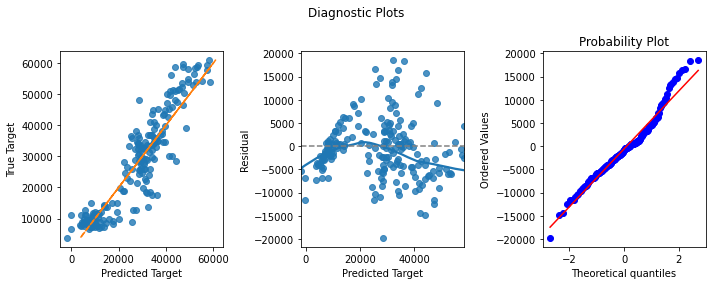

In [47]:

#created an initial graph of my progress modeled on lecture code; although my fit was strong, my residuals point to a hidden polynomial relationship.

y_pred =lasso_model.predict(X_test_scaled)
y_true = y_test
resid = y_pred-y_true

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

g1 = sns.regplot(x=y_pred, y=y_true, fit_reg=False, ax=axes[0])
g1.set_xlabel('Predicted Target')
g1.set_ylabel('True Target')
g1.plot(y_true, y_true, '--')

g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1])
g2.set_xlabel('Predicted Target')
g2.set_ylabel('Residual')
g2.axhline(y=0, color='gray', linestyle='--')

stats.probplot(resid, dist="norm", plot=axes[2])

fig.suptitle('Diagnostic Plots');
fig.tight_layout();

Since I had already removed variables I thought could be problematic, my best choice is to add engineered features. While I had added dummy variables already, extra engineered ones could be useful. Here are my best options below.
 

In [48]:
#created options below, to try out in groups or individually
aid_per = final_df.total_grants/final_df.total_pop
ratio2 = final_df.ratio**2
test_score2 = final_df.test_score**2
acceptance_perc2 = final_df.acceptance_perc**2
full_time_perc2 = final_df.full_time_perc**2
# full_time_perc_log= np.log(final_df.full_time_perc+1)
# white_perc_log = np.log(final_df.white_perc+1)
# young_perc_log = np.log(final_df.young_perc+1)
# in_state_perc_log = np.log(final_df.in_state_perc+1)
crime_rate = (final_df.crimes + final_df.VAWA + final_df.arrests)/final_df.total_pop
young_white_male = final_df.young_perc * final_df.male_perc * final_df.white_perc


In [49]:
feature_options = [aid_per, ratio2, test_score2, acceptance_perc2, full_time_perc2, crime_rate, young_white_male]

feature_options = [pd.Series(i) for i in feature_options]

In [50]:
feature_options

[ID
 100654    0.233312
 100663    0.095471
 100706    0.137966
 100724    0.206683
 100751    0.137822
             ...   
 483018    0.221053
 484905    0.092896
 486901    0.172519
 487524    0.154915
 495767    0.103285
 Length: 1021, dtype: float64,
 ID
 100654    400
 100663    361
 100706    361
 100724    225
 100751    400
          ... 
 483018     16
 484905    289
 486901     81
 487524    169
 495767    225
 Name: ratio, Length: 1021, dtype: int64,
 ID
 100654    216225
 100663    364816
 100706    422500
 100724    223729
 100751    360000
            ...  
 483018    384400
 484905    180625
 486901    344569
 487524    275625
 495767    350464
 Name: test_score, Length: 1021, dtype: int64,
 ID
 100654    8100
 100663    6561
 100706    5929
 100724    9801
 100751    6400
           ... 
 483018    7225
 484905    8649
 486901    9801
 487524    7225
 495767    6084
 Name: acceptance_perc, Length: 1021, dtype: int64,
 ID
 100654     8836
 100663     5625
 100706     705

In [51]:
#I created a function for plugging in the various features and pulling out all essential details
def tester (features):
    final_df_temp = final_df.iloc[:,1:].copy()
    for count, i in enumerate(features):
        final_df_temp[count] = i
    
    X_total = final_df_temp
    y_total = final_df["tuition"]
    
    # hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X_total, y_total, test_size=.2, random_state=5)

    # hold out 20% for validation in non-CV tests
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=10)

    scaler = StandardScaler()

    #scaled data, values used to not interfere with columns

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_scaled = scaler.transform(X.values)
    X_total_scaled = scaler.transform(X_total.values)
    X_test_scaled = scaler.transform(X_test.values)

    #create polynomial features
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_scaled_poly = poly.transform(X.values)
    X_test_poly = poly.transform(X_test.values)





    lm.fit(X, y)
    lm_final_score = lm.score(X_test, y_test)

    lm_poly.fit(X_train_poly, y_train)
    poly_final_score = lm_poly.score(X_test_poly, y_test)
    alphavec = 10**np.linspace(-2,2,200)
    
    #lasso
    lasso_model = LassoCV(alphas = alphavec, cv=5)
    lasso_model.fit(X_scaled, y)

    a = lasso_model.alpha_
    lasso_model = Lasso(alpha =a)
    lasso_model.fit(X_scaled, y)
    lasso_final_score = lasso_model.score(X_test_scaled, y_test)
    
    #ridge
    alphavec = 10**np.linspace(-2,2,200)
    
    ridge_model = RidgeCV(alphas = alphavec, cv=5)
    ridge_model.fit(X_scaled, y)
    
    a=ridge_model.alpha_
    ridge_model = Ridge(alpha = a)
    ridge_model.fit(X_scaled, y)
    
    ridge_final_score = ridge_model.score(X_test_scaled, y_test)
    
    scores = {"lm": np.mean(cross_val_score(lm, X, y, cv=5, scoring='r2')), "pm": np.mean(cross_val_score(lm_poly, X_scaled_poly, y, cv=5, scoring='r2')), "lasso": lasso_final_score, "ridge":ridge_final_score}
    
    
    return scores



In [52]:
#example with all, and a maximum r value based on the best model.
tester(feature_options)

{'lm': 0.8337259910255621,
 'pm': -3.591199303201914,
 'lasso': 0.8481035099489981,
 'ridge': 0.8481251780643204}

In [53]:
#rather than trying out different models, I used this code to create every possible combination of features to be added, and will run all combinations on top of my original model.
import itertools
combinations = []
for i in range(0, len(feature_options)+1):
    for subset in itertools.combinations(feature_options, i):
        combinations.append(subset)
        
len(combinations)
#track which combo is which 
numbers = []
for i in range(0, 8):
    for subset in itertools.combinations([1,2,3,4,5,6,7], i):
        numbers.append(subset)
combinations = [(combinations[i],numbers[i]) for i in range(128)]
combinations

[((), ()),
 ((ID
   100654    0.233312
   100663    0.095471
   100706    0.137966
   100724    0.206683
   100751    0.137822
               ...   
   483018    0.221053
   484905    0.092896
   486901    0.172519
   487524    0.154915
   495767    0.103285
   Length: 1021, dtype: float64,),
  (1,)),
 ((ID
   100654    400
   100663    361
   100706    361
   100724    225
   100751    400
            ... 
   483018     16
   484905    289
   486901     81
   487524    169
   495767    225
   Name: ratio, Length: 1021, dtype: int64,),
  (2,)),
 ((ID
   100654    216225
   100663    364816
   100706    422500
   100724    223729
   100751    360000
              ...  
   483018    384400
   484905    180625
   486901    344569
   487524    275625
   495767    350464
   Name: test_score, Length: 1021, dtype: int64,),
  (3,)),
 ((ID
   100654    8100
   100663    6561
   100706    5929
   100724    9801
   100751    6400
             ... 
   483018    7225
   484905    8649
   486901    

In [54]:
max_r = [0,0,0,0]
best = [0,0,0,0]
for count, i in enumerate(combinations):
    try:    
        dicty = tester(i[0])
        
        if  dicty["lm"]>max_r[0]:
            max_r[0]=dicty["lm"]
            best[0] = combinations[count][1]
        if  dicty["pm"]>max_r[1]:
            max_r[1]=dicty["pm"]
            best[1] = combinations[count][1]
        if  dicty["lasso"]>max_r[2]:
            max_r[2]=dicty["lasso"]
            best[2] = combinations[count][1]
        if  dicty["ridge"]>max_r[3]:
            max_r[3]=dicty["ridge"]
            best[3] = combinations[count][1]
    except:
        pass
max_r
best

[(3, 4), (2,), (2, 3, 4, 5), (3, 5, 6, 7)]

In [55]:
print(max_r)

#The r values are extremely close together in lasso and ridge regression, so lasso seems to be the best best for examiingin the close relationships.

[0.8350573200097111, 0.7162987804563677, 0.8481721498577064, 0.8489154677820844]


In [152]:
names = ["aid_perc", "ratio2", "test_score2", "acceptance_perc2", "full_time_perc2", "crime_rate", "young_white_male"]
for count, i in enumerate(feature_options):
    
    final_df[names[count]] = i


X_total = final_df.iloc[:,1:]
y_total = final_df["tuition"]

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X_total, y_total, test_size=.2, random_state=5)

# hold out 20% for validation in non-CV tests
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=10)

scaler = StandardScaler()

#scaled data, values used to not interfere with columns

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_scaled = scaler.transform(X.values)
X_total_scaled = scaler.transform(X_total.values)
X_test_scaled = scaler.transform(X_test.values)


#lasso
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
lasso_final_score = lasso_model.score(X_test_scaled, y_test)
list(zip(X.columns, lasso_model.coef_))

[('total_pop', -1377.3398037842699),
 ('ratio', -1252.439828273879),
 ('public', -9907.956303005405),
 ('test_score', 0.0),
 ('R_B_O', 1726.866814015677),
 ('total_grants', -0.0),
 ('total_apps', -612.0174536942509),
 ('acceptance_perc', 20.47009945261198),
 ('grad_rate', 2017.6851776836832),
 ('sports', 1662.293808041439),
 ('grad_students', 0.0),
 ('full_time_perc', 0.0),
 ('male_perc', -733.3206067190055),
 ('white_perc', -616.8060815903116),
 ('young_perc', 640.0131475749517),
 ('in_state_perc', -181.57502501619837),
 ('crimes', -0.0),
 ('VAWA', -403.91353127114536),
 ('arrests', 0.0),
 ('rural', -348.5171962775307),
 ('suburb', 0.0),
 ('town', -152.16104520880918),
 ('aid_perc', 87.29038780347683),
 ('ratio2', -0.0),
 ('test_score2', 4156.899879032145),
 ('acceptance_perc2', 0.0),
 ('full_time_perc2', 388.0215764800219),
 ('crime_rate', 0.0),
 ('young_white_male', -0.0)]

Several key relationships pop up within this analysis.

- Demographics have a key weight, but all seperately.
- While all other crime statistics dropped, VAWA remained significant.
- Suburban and Urban schools had the best results.
- Public School has a significant roll.
- The model overall seems to favor a smaller, suburban school with a rigorous acceptance metrics and a strong sport team


In [112]:
lasso_final_score


0.8477329283263817

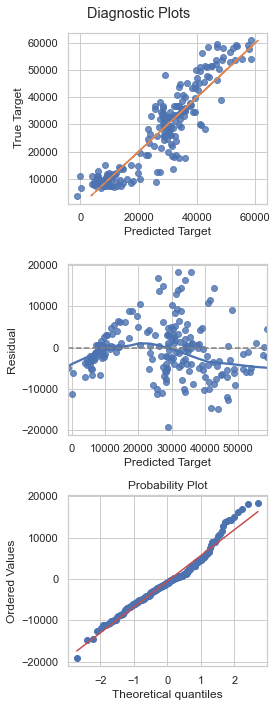

In [113]:
y_pred = lasso_model.predict(X_test_scaled)
y_true = y_test
resid = y_pred-y_true

fig, axes = plt.subplots(3, 1, figsize=(4, 10))

g1 = sns.regplot(x=y_pred, y=y_true, fit_reg=False, ax=axes[0])
g1.set_xlabel('Predicted Target')
g1.set_ylabel('True Target')
g1.plot(y_true, y_true, '--')

g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1])
g2.set_xlabel('Predicted Target')
g2.set_ylabel('Residual')
g2.axhline(y=0, color='gray', linestyle='--')

stats.probplot(resid, dist="norm", plot=axes[2])

fig.suptitle('Diagnostic Plots');
fig.tight_layout();

In [114]:
#predict best schools
predicted = lasso_model.predict(X_total_scaled)-y_total
final_df_pred = final_df.copy()
final_df_pred["value_diff"] = predicted
school_names_ref = school_names.set_index("UnitID")
final_df_pred[["Name", "City", "State"]] = school_names_ref[school_names_ref.index.isin(final_df_pred.index)]


#Most valuable schools - these schools have the largest differential in 
final_df_pred[(final_df_pred["value_diff"]>10000) & (final_df_pred["total_pop"]>500)].sort_values("value_diff").tail(10)



tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
215132    27500       2285     11       0         607  17166           426   
199120     8980      29877     13       1         692  11740          1788   
100937    18900       1209     11       0         552   8000           326   
153108    18600       1163     13       0         541  10280           337   
239071    17650        985     11       0         612  11260           112   
176053    19308       4733     14       0         600  11587           460   
177968    18100       8392     12       0         542  13670           778   
176479    13650       5040     15       0         595   6540           198   
230047     5890       3096     16       0         577   4800           370   
230038     5970      34318     20       0         652   7808          2996   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
215132        3129               71         81  ...     121       368449   
199120       41773               25         91  ...     169       478864   
100937        2460               60         71  ...     121       304704   
153108        2340               64         68  ...     169       292681   
239071         282               80         56  ...     121       374544   
176053        2559               29         65  ...     196       360000   
177968        2695               92         47  ...     144       293764   
176479         758               55         53  ...     225       354025   
230047        1573               75         67  ...     256       332929   
230038       11292               69         75  ...     400       425104   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
215132              5041             9801    0.009628            156816   
199120               625             9409    0.022091            228920   
100937              3600             9801    0.027295            367587   
153108              4096             9216    0.039553            422968   
239071              6400             4096    0.003046            311696   
176053               841             7225    0.004648            259880   
177968              8464             7744    0.015848            197505   
176479              3025             3481    0.004167            177408   
230047              5625             8464    0.019057             88350   
230038              4761             8100    0.004604            360450   

          value_diff                                         Name  \
ID                                                                  
215132  16737.087407                   University of the Sciences   
199120  16902.175049  University of North Carolina at Chapel Hill   
100937  17049.528522                  Birmingham-Southern College   
153108  17473.426703                              Central College   
239071  18181.001766                 Maranatha Baptist University   
176053  18256.134690                          Mississippi College   
177968  18288.400020                        Lindenwood University   
176479  18302.725853                     William Carey University   
230047  24261.825607              Brigham Young University-Hawaii   
230038  29909.036298               Brigham Young University-Provo   

                 City  State  
ID                            
215132   Philadelphia     PA  
199120    Chapel Hill     NC  
100937     Birmingham     AL  
153108          Pella     IA  
239071      Watertown     WI  
176053        Clinton     MS  
177968  Saint Charles     MO  
176479    Hattiesburg     MS  
230047           Laie     HI  
230038          Provo     UT  

[10 rows x 34 columns]

In [115]:
#least valuable schools
final_df_pred[(final_df_pred["value_diff"]<-10000) & (final_df_pred["total_pop"]>500)].sort_values("value_diff").head(10)



tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
174792    48166       1727     11       0         535  11362           413   
147776    11827       7423     13       1         455   4212           360   
232256    48110        993     10       0         565  11408           228   
239628    47123        787     13       0         535   6750           221   
195216    58750       2434     11       0         635   6750           584   
191533    48364       1193      9       0         550   6000           376   
228246    58540      11824     11       0         675   8700          1159   
111948    57214       9850     13       0         630  12430          1488   
212054    56238      24205     11       0         640  17262          3159   
216852    48575       6496     13       0         561   8190           704   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
174792        1595               81         74  ...     121       286225   
147776        4885               61         23  ...     169       207025   
232256        1906               47         71  ...     100       319225   
239628        2614               74         67  ...     169       286225   
195216        5952               47         80  ...     121       403225   
191533        3609               93         58  ...      81       302500   
228246       14010               53         81  ...     121       455625   
111948       14252               58         80  ...     169       396900   
212054       31237               77         71  ...     121       409600   
216852        5739               75         65  ...     169       314721   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
174792              6561             9604    0.072380            772200   
147776              3721             3364    0.004311             67338   
232256              2209             9801    0.105740            833085   
239628              5476             9604    0.039390            355212   
195216              2209             9801    0.029992            346500   
191533              8649             9604    0.050293            245520   
228246              2809             9409    0.038058            319872   
111948              3364             8836    0.008122            196000   
212054              5929             8100    0.005164            234000   
216852              5625             7396    0.005696            275544   

          value_diff                              Name            City  State  
ID                                                                             
174792 -19211.382374            Saint Johns University    Collegeville     MN  
147776 -16217.426842  Northeastern Illinois University         Chicago     IL  
232256 -15416.448516            Hampden-Sydney College  Hampden-Sydney     VA  
239628 -15410.637642                     Ripon College           Ripon     WI  
195216 -15070.477760            St Lawrence University          Canton     NY  
191533 -14938.584237                  Hartwick College         Oneonta     NY  
228246 -14758.573492     Southern Methodist University          Dallas     TX  
111948 -14530.420445                Chapman University          Orange     CA  
212054 -14521.339912                 Drexel University    Philadelphia     PA  
216852 -14234.217121                Widener University         Chester     PA  

[10 rows x 34 columns]

In [116]:
#most accurate schools
final_df_pred[(final_df_pred["value_diff"].abs()<100) & (final_df_pred["total_pop"]>500)].sort_values("value_diff").head(10)




tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
232706    34540       3363     12       0         535  14454           380   
203775    32416       1524     11       0         542   8000           239   
186876    14329       9934     17       1         550  12605          1229   
136330    33475       3691     12       0         552   9869           518   
199412    37332       2463     10       0         567   9738           332   
110538     7864      17110     24       1         535  11314          1643   
101709    13710       2553     13       1         551   9810           466   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
232706        3046               85         54  ...     144       286225   
203775        1306               74         54  ...     121       293764   
186876        7262               77         74  ...     289       302500   
136330        1581               92         57  ...     144       304704   
199412        3437               68         57  ...     100       321489   
110538       19999               90         65  ...     576       286225   
101709        4954               61         54  ...     169       303601   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
232706              7225             8100    0.016354             88970   
203775              5476             6400    0.004593            268047   
186876              5929             9025    0.015402            237185   
136330              8464             6241    0.005960            194287   
199412              4624             8281    0.034511            151536   
110538              8100             8649    0.009001            173806   
101709              3721             7921    0.010967            224595   

        value_diff                               Name             City  State  
ID                                                                             
232706  -46.737533               Marymount University        Arlington     VA  
203775  -40.932467                  Malone University           Canton     OH  
186876   31.629883                Stockton University         Galloway     NJ  
136330   32.403887     Palm Beach Atlantic University  West Palm Beach     FL  
199412   52.685491     Queens University of Charlotte        Charlotte     NC  
110538   58.959436  California State University-Chico            Chico     CA  
101709   93.433629           University of Montevallo       Montevallo     AL  

[7 rows x 34 columns]

In [117]:
#How does the Ivy League Do?
final_df_pred[final_df_pred["Name"].isin(["Harvard University", "Brown University", "Princeton University", "Yale University", "Cornell University", "Dartmouth College"])]

tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
130794    57700      13609      6       0         760  17200           819   
166027    54002      31655      7       0         760  18389           944   
182670    60117       6606      7       0         750  17022           532   
186131    48502       8419      5       0         755  15342           809   
190415    59282      24027      9       0         735  15396          1489   
217156    60696      10333      6       0         750  15908           726   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
130794       35220                7         96  ...      36       577600   
166027       40248                5         98  ...      49       577600   
182670       21392                9         95  ...      49       562500   
186131       32835                6         98  ...      25       570025   
190415       51500               11         95  ...      81       540225   
217156       36793                8         95  ...      36       562500   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
130794                49            10000    0.026527            194040   
166027                25             5041    0.012921            150822   
182670                81             9801    0.042083            252450   
186131                36             9604    0.031714            198000   
190415               121            10000    0.014983            163944   
217156                64             9025    0.017710            190773   

          value_diff                  Name        City  State  
ID                                                             
130794   3260.638123       Yale University   New Haven     CT  
166027   4595.661441    Harvard University   Cambridge     MA  
182670    383.684445     Dartmouth College     Hanover     NH  
186131  13241.208651  Princeton University   Princeton     NJ  
190415  -1849.084816    Cornell University      Ithaca     NY  
217156  -1566.669312      Brown University  Providence     RI  

[6 rows x 34 columns]

In [118]:
#With random forest and gradient boost, we can see a jump up to .88 and .92 respectively, which enhances the confindence in the current model's balance of explainablity and fit

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=1800, max_features=3)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

gbm = GradientBoostingRegressor(n_estimators=1600, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
gbm.score(X_val, y_val)

0.9235639478976073

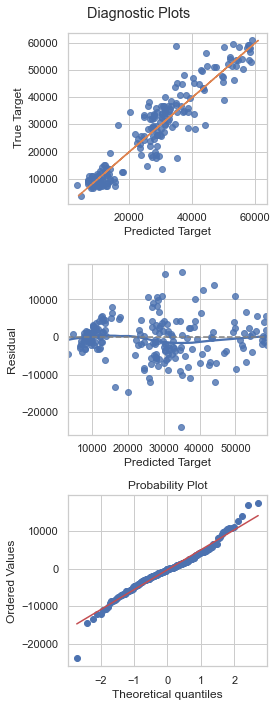

In [119]:
#Gradient boost does seem to level out the subtle curve of the residual plot.

y_pred = gbm.predict(X_test)
y_true = y_test
resid = y_pred-y_true

fig, axes = plt.subplots(3, 1, figsize=(4, 10))

g1 = sns.regplot(x=y_pred, y=y_true, fit_reg=False, ax=axes[0])
g1.set_xlabel('Predicted Target')
g1.set_ylabel('True Target')
g1.plot(y_true, y_true, '--')

g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1])
g2.set_xlabel('Predicted Target')
g2.set_ylabel('Residual')
g2.axhline(y=0, color='gray', linestyle='--')

stats.probplot(resid, dist="norm", plot=axes[2])

fig.suptitle('Diagnostic Plots');
fig.tight_layout();

In [120]:
coefs = pd.DataFrame(list(zip(X.columns, lasso_model.coef_)))
coefs.columns = ["Coefficients", "Relative Weight"]
coefs = coefs[coefs["Relative Weight"] !=0]
coefs.sort_values("Relative Weight", inplace = True)
coefs.replace({"public": "Public", "rural": "Rural", "town": "Town", "aid_perc": "% Receiving Aid", "sports":"Sports","total_pop":"Population", "ratio": "Student : Faculty", "male_perc": "% Male", "white_perc": "% White", "total_apps": "Total Applications", "in_state_perc":"% In-State", "acceptance_perc":"% Accepted", "full_time_perc2": "% Full Time^2", "young_perc": "% Below 24", "R_B_O":"Off-Campus Room and Board", "grad_rate": "Graduation Rate", "test_score2": "Test Scores^2"}, inplace = True)
coefs["Weight"] = coefs["Relative Weight"]>0
coefs.Weight = coefs.Weight.apply(lambda x : "Positive" if x else "Negative")


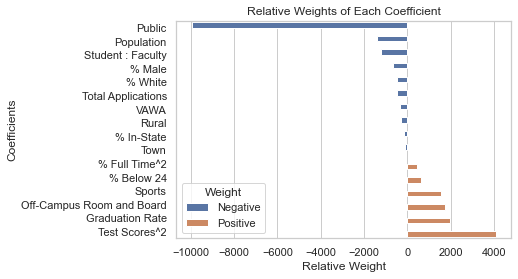

In [121]:
sns.set_theme(style="whitegrid")


g = sns.barplot(x = "Relative Weight", y = "Coefficients", data = coefs, hue= "Weight", orient = "h").set(title = "Relative Weights of Each Coefficient")

In [122]:
private = final_df_pred[final_df_pred["public"] ==0]

In [123]:
public = final_df_pred[final_df_pred["public"] ==1]

In [124]:
ivy_league = final_df_pred[final_df_pred["Name"].isin(["Harvard University", "Brown University", "Princeton University", "Yale University", "Cornell University", "Dartmouth College", "Columbia University in the City of New York", "University of Pennsylvania"])]
                           
                           
                           
                           

In [125]:
ivy_league

tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
130794    57700      13609      6       0         760  17200           819   
166027    54002      31655      7       0         760  18389           944   
182670    60117       6606      7       0         750  17022           532   
186131    48502       8419      5       0         755  15342           809   
190150    61671      31456      6       0         757  18360           774   
190415    59282      24027      9       0         735  15396          1489   
215062    60042      26675      6       0         757  14502          1106   
217156    60696      10333      6       0         750  15908           726   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
130794       35220                7         96  ...      36       577600   
166027       40248                5         98  ...      49       577600   
182670       21392                9         95  ...      49       562500   
186131       32835                6         98  ...      25       570025   
190150       40462                7         96  ...      36       573049   
190415       51500               11         95  ...      81       540225   
215062       42205                9         96  ...      36       573049   
217156       36793                8         95  ...      36       562500   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
130794                49            10000    0.026527            194040   
166027                25             5041    0.012921            150822   
182670                81             9801    0.042083            252450   
186131                36             9604    0.031714            198000   
190150                49             8836    0.007089            156520   
190415               121            10000    0.014983            163944   
215062                81             7744    0.006111            163215   
217156                64             9025    0.017710            190773   

          value_diff                                         Name  \
ID                                                                  
130794   3260.638123                              Yale University   
166027   4595.661441                           Harvard University   
182670    383.684445                            Dartmouth College   
186131  13241.208651                         Princeton University   
190150  -4574.900505  Columbia University in the City of New York   
190415  -1849.084816                           Cornell University   
215062  -2398.661234                   University of Pennsylvania   
217156  -1566.669312                             Brown University   

                City  State  
ID                           
130794     New Haven     CT  
166027     Cambridge     MA  
182670       Hanover     NH  
186131     Princeton     NJ  
190150      New York     NY  
190415        Ithaca     NY  
215062  Philadelphia     PA  
217156    Providence     RI  

[8 rows x 34 columns]

<AxesSubplot:ylabel='value_diff'>

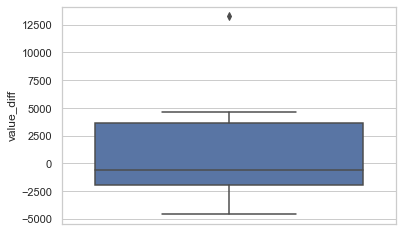

In [126]:
sns.boxplot(y= "value_diff", data= ivy_league)

<AxesSubplot:ylabel='value_diff'>

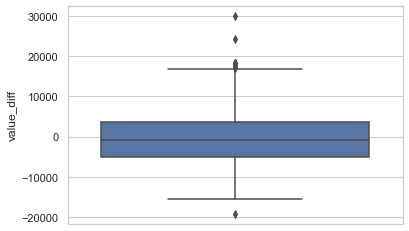

In [127]:
sns.boxplot(y= "value_diff", data= private)

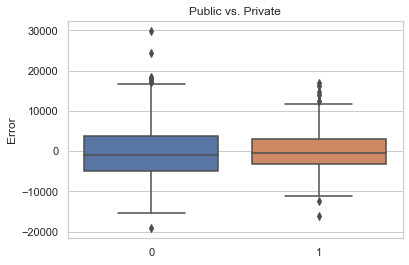

In [128]:
# final_df_pred["public"] = final_df_pred["public"].apply(lambda x: "Public" if x >0 else "Private")

g= sns.boxplot(x = "public" , y= "value_diff", data= final_df_pred).set(title = "Public vs. Private",  xlabel = None, ylabel = "Error")



In [129]:
final_df_pred.head(20)

tuition  total_pop  ratio  public  test_score  R_B_O  total_grants  \
ID                                                                           
100654    10024       6172     20       1         465   9240          1440   
100663     8568      22080     19       1         604  12307          2108   
100706    11338       9988     19       1         650  10652          1378   
100724    11068       4190     15       1         473   7320           866   
100751    11620      38100     20       1         600  13810          5251   
100830     8860       5188     16       1         500  10296           580   
100858    11796      30460     20       1         620  13778          3194   
100937    18900       1209     11       0         552   8000           326   
101189    22990       3036     13       0         548   8200           256   
101435    27900       1008     13       0         540  10150           255   
101480    11120       9021     18       1         477   9648          1460   
101541    18640        250      5       0         580   7110            46   
101709    13710       2553     13       1         551   9810           466   
102049    34198       5692     12       0         575  11250           892   
102094     8396      14397     17       1         543   9020          1438   
102234    41868       1290     13       0         537  17552           292   
102368     8908      16436     15       1         510   7586          1107   
102377    22614       2876     10       0         476  10055           451   
102614     7176       7179     10       1         580  12050           483   
104151    11338      53286     20       1         605   9684         12468   

        total_apps  acceptance_perc  grad_rate  ...  ratio2  test_score2  \
ID                                              ...                        
100654        9855               90         29  ...     400       216225   
100663       10391               81         61  ...     361       364816   
100706        5793               77         57  ...     361       422500   
100724        7027               99         32  ...     225       223729   
100751       39560               80         72  ...     400       360000   
100830        4606               96         30  ...     256       250000   
100858       17946               85         79  ...     400       384400   
100937        2460               60         71  ...     121       304704   
101189        1572               76         27  ...     169       300304   
101435        2129               54         42  ...     169       291600   
101480       10932               64         46  ...     324       227529   
101541         432               56         48  ...      25       336400   
101709        4954               61         54  ...     169       303601   
102049        3867               84         77  ...     144       330625   
102094        8084               73         45  ...     289       294849   
102234        2742               54         57  ...     169       288369   
102368        7018               92         50  ...     225       260100   
102377       11113               61         52  ...     100       226576   
102614        1361               67         39  ...     100       336400   
104151       53516               88         66  ...     400       366025   

        acceptance_perc2  full_time_perc2  crime_rate  young_white_male  \
ID                                                                        
100654              8100             8836    0.028192              3840   
100663              6561             5625    0.012908            171600   
100706              5929             7056    0.009812            350030   
100724              9801             8464    0.034606              6882   
100751              6400             7921    0.016089            311696   
100830              9216             5929    0.011951            121660   
100858            

Just to experiment, I tried this relatioship. It changed the whole project.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='test_score', ylabel='tuition'>

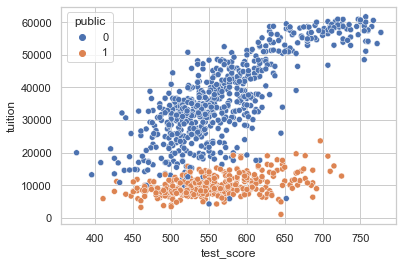

In [130]:
sns.scatterplot("test_score","tuition", data = final_df_pred, hue = "public")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='public_test_scores', ylabel='tuition'>

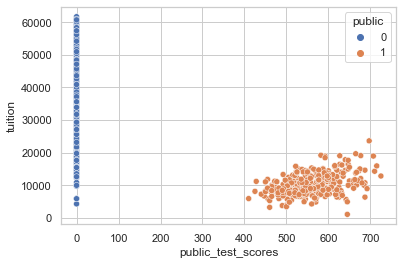

In [135]:
final_df_pred["public_test_scores"] = final_df_pred["public"]*final_df_pred["test_score"]

sns.scatterplot("public_test_scores","tuition", data = final_df_pred, hue = "public")

In [136]:
#after errors copy pasting code, I wanted to look at this carefully

careful_df= final_df.copy()

In [137]:
feature_options[0]

ID
100654    0.233312
100663    0.095471
100706    0.137966
100724    0.206683
100751    0.137822
            ...   
483018    0.221053
484905    0.092896
486901    0.172519
487524    0.154915
495767    0.103285
Length: 1021, dtype: float64

In [138]:
careful_df["public_test_scores"] = careful_df["public"]*careful_df["test_score"]
names= ["aid_perc", "ratio2", "test_score2", "acceptance_perc2", "full_time_perc2", "crime_rate", "young_white_male"]
for i, series in enumerate(feature_options):
    careful_df[names[i]] = series

In [153]:
# I ran the code below for all models, with similar results

#standardize and prepare datasets for analsysis
X_total = careful_df.iloc[:,1:].drop(["crimes","arrests","total_grants", "total_apps"], axis =1)
y_total = careful_df["tuition"]


# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X_total, y_total, test_size=.2, random_state=5)

# hold out 20% for validation in non-CV tests
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=10)

scaler = StandardScaler()

#scaled data, values used to not interfere with columns

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_scaled = scaler.transform(X.values)
X_total_scaled = scaler.transform(X_total.values)
X_test_scaled = scaler.transform(X_test.values)

#create polynomial features
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_scaled_poly = poly.transform(X.values)
X_test_poly = poly.transform(X_test.values)

# lm = LinearRegression()
# lm.fit(X_scaled, y)

# np.mean(cross_val_score(lm, X, y, cv=5, scoring='r2'))


alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
print(lasso_model.alpha_)


print(lasso_model.score(X_test_scaled, y_test))

list(zip(X_train.columns, lasso_model.coef_))

0.16831803533309567
0.8679282614041396


[('total_pop', -1154.5756255901224),
 ('ratio', 315.9996186286409),
 ('public', 16926.503228139743),
 ('test_score', -3076.194463488769),
 ('R_B_O', 1567.0768552404472),
 ('acceptance_perc', 5628.245734476197),
 ('grad_rate', 1763.9562602565945),
 ('sports', 1761.5157062947073),
 ('grad_students', 249.0117128935568),
 ('full_time_perc', -1201.9773066209323),
 ('male_perc', -629.6956654294071),
 ('white_perc', -704.4301365415267),
 ('young_perc', 352.1047622658704),
 ('in_state_perc', 504.0474900924189),
 ('VAWA', -299.4013915617514),
 ('rural', -385.3611138383275),
 ('suburb', 187.42446770056404),
 ('town', -404.5511564702357),
 ('aid_perc', 186.72602427967507),
 ('ratio2', -1372.9642435933365),
 ('test_score2', 9849.35168759032),
 ('acceptance_perc2', -4754.378529886776),
 ('full_time_perc2', 1689.6981124999472),
 ('crime_rate', 92.61511777409049),
 ('young_white_male', 346.06782650052554),
 ('public_test_scores', -27857.042344933834)]

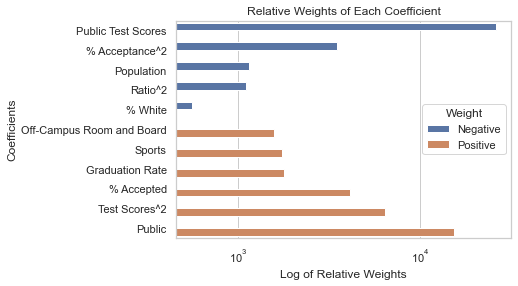

In [149]:
coefs = pd.DataFrame(list(zip(X.columns, lasso_model.coef_)))
coefs.columns = ["Coefficients", "Relative Weight"]
coefs = coefs[coefs["Relative Weight"].abs() >500]
coefs.sort_values("Relative Weight", inplace = True)
coefs.replace({"public_test_scores":"Public Test Scores","acceptance_perc2":"% Acceptance^2","ratio2": "Ratio^2", "public": "Public", "rural": "Rural", "town": "Town", "aid_perc": "% Receiving Aid", "sports":"Sports","total_pop":"Population", "ratio": "Student : Faculty", "male_perc": "% Male", "white_perc": "% White", "total_apps": "Total Applications", "in_state_perc":"% In-State", "acceptance_perc":"% Accepted", "full_time_perc2": "% Full Time^2", "young_perc": "% Below 24", "R_B_O":"Off-Campus Room and Board", "grad_rate": "Graduation Rate", "test_score2": "Test Scores^2"}, inplace = True)
coefs["Weight"] = coefs["Relative Weight"]>0
coefs.Weight = coefs.Weight.apply(lambda x : "Positive" if x else "Negative")
coefs["Abs_Weight"] = coefs["Relative Weight"].abs()
coefs = coefs[coefs["Coefficients"] != "young_white_male"]
sns.set_theme(style="whitegrid")


g = sns.barplot(x = "Abs_Weight", y = "Coefficients", data = coefs, hue= "Weight", orient = "h").set(title = "Relative Weights of Each Coefficient", xscale="log", xlabel = "Log of Relative Weights")



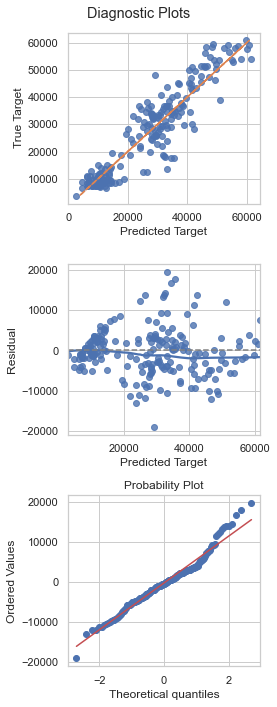

In [151]:
y_pred = lasso_model.predict(X_test_scaled)
y_true = y_test
resid = y_pred-y_true

fig, axes = plt.subplots(3, 1, figsize=(4, 10))

g1 = sns.regplot(x=y_pred, y=y_true, fit_reg=False, ax=axes[0])
g1.set_xlabel('Predicted Target')
g1.set_ylabel('True Target')
g1.plot(y_true, y_true, '--')

g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1])
g2.set_xlabel('Predicted Target')
g2.set_ylabel('Residual')
g2.axhline(y=0, color='gray', linestyle='--')

stats.probplot(resid, dist="norm", plot=axes[2])

fig.suptitle('Diagnostic Plots');
fig.tight_layout();